In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [4]:
evds=evdsAPI('dsIC3fiGlu')


In [5]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4583,28-08-2023,26.4536
4584,29-08-2023,26.5749
4586,31-08-2023,26.6242
4587,01-09-2023,26.7138


In [6]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd=usd.head(211)
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-04-30,19.337032
2023-05-31,19.719514
2023-06-30,23.106042


In [7]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


In [8]:
inflation=enf
inflation=pd.DataFrame(inflation)
inflation.columns=["Tarih","TÜFE"]


In [10]:

inflationagt=pd.DataFrame.from_dict(inflation)
inflation=pd.concat([inflation,inflationagt],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


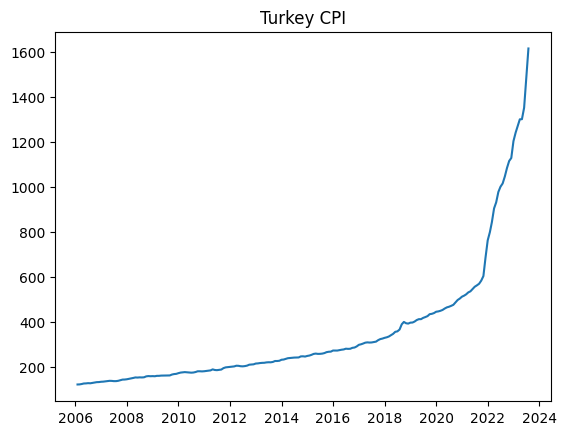

In [12]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflationagt["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [13]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-04-30,19.337032
2023-05-31,19.719514
2023-06-30,23.106042


In [14]:
dates= pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6

,USD/TL,Onceki USD/TL
2006-02-01,1.326535,1.320000
2006-03-01,1.335139,1.326535
2006-04-01,1.337345,1.335139
2006-05-01,1.420659,1.337345
2006-06-01,1.600536,1.420659
...,...,...
2023-04-01,19.337032,19.003478
2023-05-01,19.719514,19.337032
2023-06-01,23.106042,19.719514
2023-07-01,26.470338,23.106042


In [15]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [16]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [17]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn["Para Arzi Onceki"]=dfn["Para Arzi"].shift(1)
dfn.iloc[0,1]=2.39
dfn


,Para Arzi,Para Arzi Onceki
2006-02-01,2.423895,2.390000
2006-03-01,2.494857,2.423895
2006-04-01,2.521919,2.494857
2006-05-01,2.751947,2.521919
2006-06-01,2.791388,2.751947
...,...,...
2023-04-01,95.059993,90.592762
2023-05-01,94.093167,95.059993
2023-06-01,108.345324,94.093167
2023-07-01,114.784753,108.345324


In [18]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4574,15-08-2023,86.28
4575,16-08-2023,84.49
4576,17-08-2023,85.24
4577,18-08-2023,85.92


In [19]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle
brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-04-30,84.739474
2023-05-31,75.466000
2023-06-30,74.839091


In [20]:

brent1=pd.DataFrame(brent)
brent1.columns=["Brent"]
brent1


,Brent
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-04-30,84.739474
2023-05-31,75.466000
2023-06-30,74.839091


In [21]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1501373576.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Brent
TIME,
2006-02-01,60.210000
2006-03-01,62.064783
2006-04-01,70.260000
2006-05-01,69.776957
2006-06-01,68.555909
...,...
2023-04-01,84.739474
2023-05-01,75.466000
2023-06-01,74.839091


In [22]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
206,2023-4,8.572114e+09
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09


In [23]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
206,2023-4,85.721139
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952


In [24]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\2513009782.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-04-01,85.721139
2023-05-01,88.043441
2023-06-01,95.646045


In [25]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.iloc[:59,1]=5
pfaiz.iloc[210,1]=25
pfaiz=pfaiz.head(211)
pfaiz

,Tarih,TP_APIFON4
0,2006-2,5.00
1,2006-3,5.00
2,2006-4,5.00
3,2006-5,5.00
4,2006-6,5.00
...,...,...
206,2023-4,8.70
207,2023-5,9.09
208,2023-6,12.84
209,2023-7,17.50


In [26]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\482091913.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)


,Politika Faizi
TIME,
2006-02-01,5.00
2006-03-01,5.00
2006-04-01,5.00
2006-05-01,5.00
2006-06-01,5.00
...,...
2023-04-01,8.70
2023-05-01,9.09
2023-06-01,12.84


In [27]:
X=pd.concat([df6["Onceki USD/TL"],dfn["Para Arzi Onceki"],df14.Brent,df3.Kredi,pfaiz["Politika Faizi"]],axis=1)



In [28]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y


,CPI
2006-02-01,123.84
2006-03-01,124.18
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
...,...
2023-04-01,1300.04
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [32]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     8996.
Date:                Mon, 04 Sep 2023   Prob (F-statistic):          1.11e-174
Time:                        16:33:21   Log-Likelihood:                -608.62
No. Observations:                 147   AIC:                             1229.
Df Residuals:                     141   BIC:                             1247.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               82.9835      5.166  

In [33]:
results.params

const               82.983512
Onceki USD/TL       13.525604
Para Arzi Onceki     7.133017
Brent                0.240436
Kredi                2.991436
Politika Faizi       0.013806
dtype: float64

In [86]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df14.astype(float),
                                order=(0,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [87]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [88]:
pred_ci['Predicted'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
pred_ci['Observed'] = df14["Brent"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Brent,upper Brent,Predicted,Observed,"Diff, %%"
2022-11-01,79.239893,109.282550,94.261221,91.415455,3.113004
2022-12-01,76.660233,106.702891,91.681562,80.996667,13.191772
2023-01-01,70.443274,100.485931,85.464603,82.515909,3.573485
2023-02-01,69.755565,99.798223,84.776894,82.585000,2.654107
2023-03-01,66.434747,96.477404,81.456076,78.434348,3.852557
2023-04-01,52.736866,82.779524,67.758195,84.739474,-20.039396
2023-05-01,78.240109,108.282767,93.261438,75.466000,23.580736
2023-06-01,69.646212,99.688870,84.667541,74.839091,13.132776
2023-07-01,57.116686,87.159344,72.138015,80.108095,-9.949157
2023-08-01,60.287448,90.330106,75.308777,86.456000,-12.893522


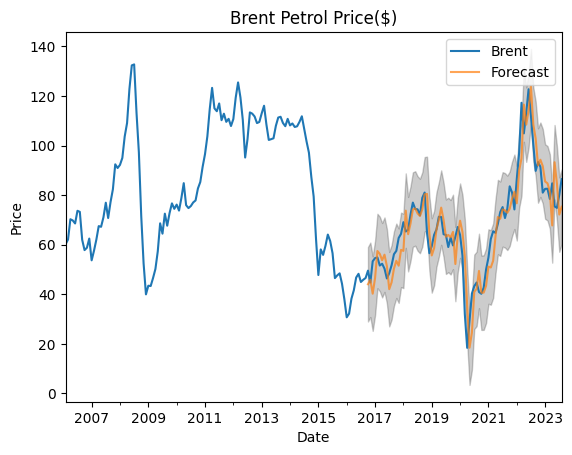

In [37]:
ax = df14['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [89]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

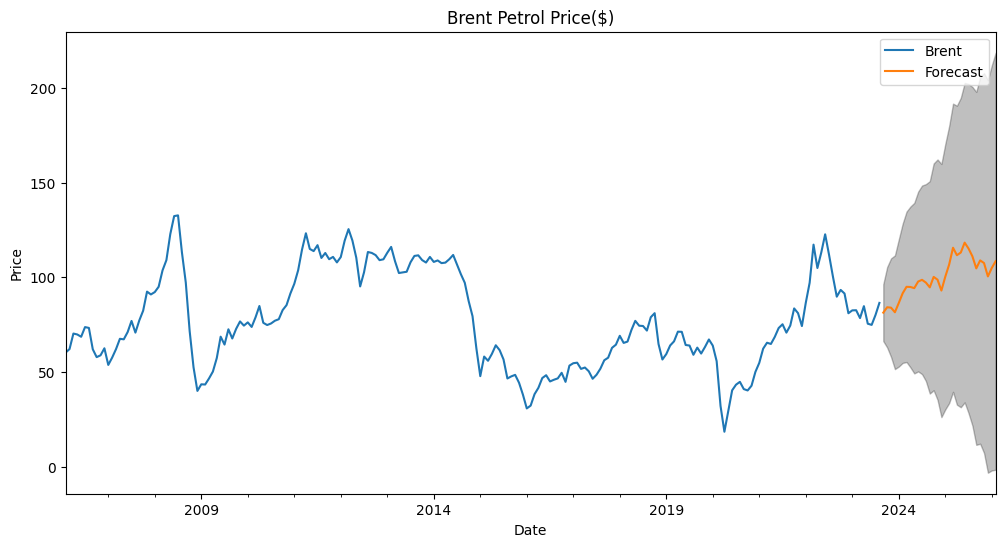

In [39]:
ax = df14.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [90]:
pred_ci['Mean'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
brenttahmin=pred_ci["Mean"]
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]
brenttahmin



,Brent
2023-09-01,81.313642
2023-10-01,84.152628
2023-11-01,83.950575
2023-12-01,81.514422
2024-01-01,86.407891
2024-02-01,91.531514
2024-03-01,94.958657
2024-04-01,94.878520
2024-05-01,94.266103
2024-06-01,97.750983


In [91]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(dfn["Para Arzi Onceki"].astype(float),
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [92]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [93]:
pred_ci['Predicted'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
pred_ci['Observed'] = dfn["Para Arzi Onceki"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Para Arzi Onceki,upper Para Arzi Onceki,Predicted,Observed,"Diff, %%"
2022-11-01,76.363207,80.447239,78.405223,77.750311,0.842327
2022-12-01,79.789153,83.873017,81.831085,79.312824,3.175099
2023-01-01,80.898899,84.982596,82.940748,82.127970,0.989648
2023-02-01,83.540276,87.623811,85.582043,84.330974,1.483523
2023-03-01,85.914933,89.998468,87.956700,86.852197,1.271705
2023-04-01,89.281281,93.364653,91.322967,90.592762,0.806031
2023-05-01,92.890070,96.973282,94.931676,95.059993,-0.134985
2023-06-01,97.779678,101.862733,99.821205,94.093167,6.087624
2023-07-01,96.514699,100.597599,98.556149,108.345324,-9.035161
2023-08-01,111.519008,115.601756,113.560382,114.784753,-1.066667


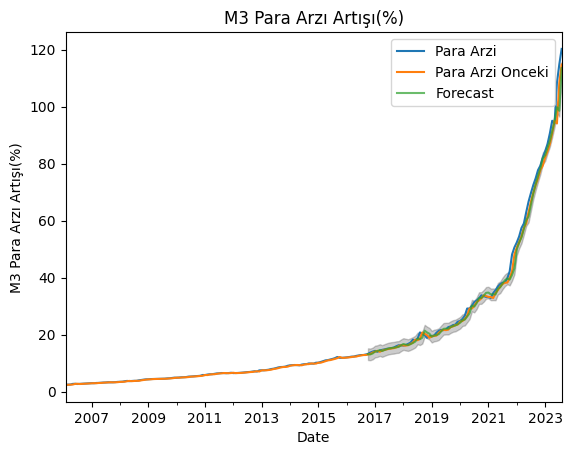

In [94]:
ax = dfn['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('M3 Para Arzı Artışı(%)')
plt.title("M3 Para Arzı Artışı(%)")
plt.legend()
plt.show()

In [95]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

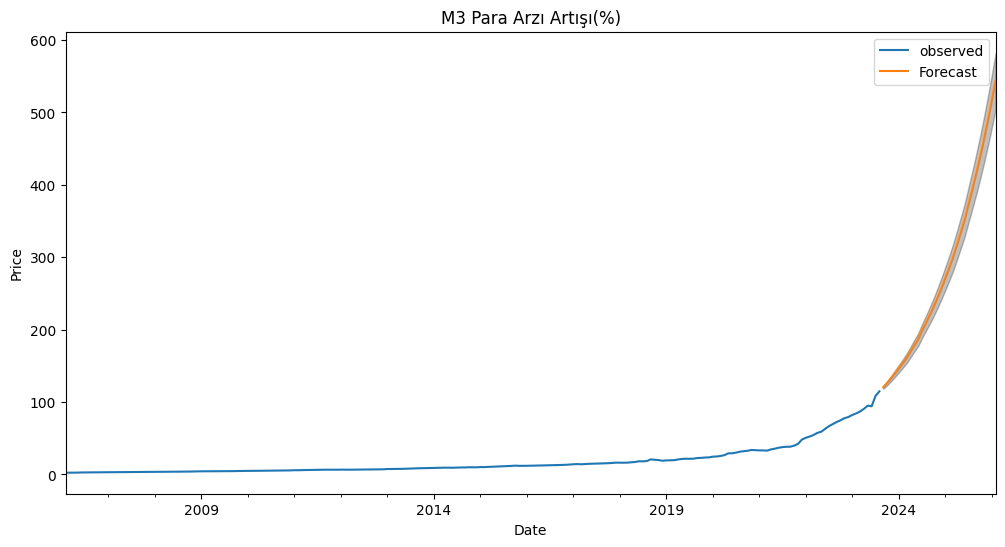

In [96]:
ax = dfn["Para Arzi Onceki"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("M3 Para Arzı Artışı(%)")

plt.legend()

plt.show()

In [98]:
import random
import numpy as np
pred_ci['Mean'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
paraarzitahmin=pred_ci["Mean"]
paraarzitahmin=pd.DataFrame(paraarzitahmin)
paraarzitahmin.columns=["Para Arzi Tahmin"]
paraarzitahmin




,Para Arzi Tahmin
2023-09-01,120.343514
2023-10-01,126.071249
2023-11-01,132.386959
2023-12-01,139.076031
2024-01-01,145.980097
2024-02-01,152.864896
2024-03-01,160.234037
2024-04-01,168.816121
2024-05-01,177.730610
2024-06-01,186.123642


In [99]:
y=float(input('Para Arzi Aylık En Fazla % Kaç Artacağını Girin: '))
def paraarziassumption(y):
   drop_percentage = random.uniform(1+(y/300), 1+(y/100))
   
   paraarzitahmin["Para Arzi Assumption 2"]=paraarzitahmin["Para Arzi Tahmin"]
   
   for i in range(0, len(paraarzitahmin)-1):
   
      paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
   return paraarzitahmin
      
paraarziassumption(y)


C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1571707984.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1571707984.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1571707984.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,Para Arzi Tahmin,Para Arzi Assumption 2
2023-09-01,120.343514,120.343514
2023-10-01,126.071249,122.086548
2023-11-01,132.386959,123.854827
2023-12-01,139.076031,125.648717
2024-01-01,145.980097,127.468590
2024-02-01,152.864896,129.314822
2024-03-01,160.234037,131.187794
2024-04-01,168.816121,133.087893
2024-05-01,177.730610,135.015514
2024-06-01,186.123642,136.971054


In [100]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df6["USD/TL"].astype(float),
                                order=(0,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [101]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [102]:
pred_ci['Predicted'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
pred_ci['Observed'] = df6["USD/TL"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower USD/TL,upper USD/TL,Predicted,Observed,"Diff, %%"
2022-11-01,18.248625,19.764554,19.006589,18.624382,2.052188
2022-12-01,18.097284,19.613213,18.855249,18.670545,0.989276
2023-01-01,17.569546,19.085475,18.327511,18.791373,-2.468484
2023-02-01,18.159739,19.675668,18.917704,18.857210,0.320798
2023-03-01,18.674088,20.190018,19.432053,19.003478,2.255243
2023-04-01,18.387043,19.902973,19.145008,19.337032,-0.993036
2023-05-01,19.062290,20.578219,19.820254,19.719514,0.510864
2023-06-01,19.353773,20.869702,20.111738,23.106042,-12.958968
2023-07-01,24.480974,25.996903,25.238939,26.470338,-4.651997
2023-08-01,26.621639,28.137569,27.379604,26.999127,1.409219


In [103]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

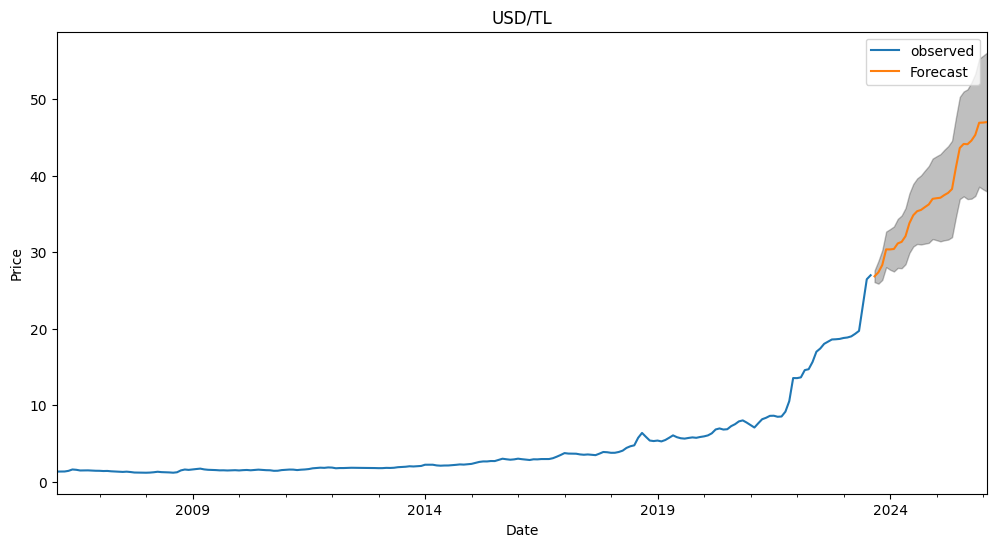

In [53]:
ax = df6["USD/TL"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL")

plt.legend()

plt.show()

In [104]:
pred_ci['Mean'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
usdtahmin=pred_ci["Mean"]
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD Tahmin"]







usdtahmin

,USD Tahmin
2023-09-01,26.853734
2023-10-01,27.376681
2023-11-01,28.336827
2023-12-01,30.376779
2024-01-01,30.371202
2024-02-01,30.429898
2024-03-01,31.156774
2024-04-01,31.361308
2024-05-01,32.106386
2024-06-01,33.799436


In [105]:
import random
x=float(input('Dolar/TL Aylık En Fazla % Kaç Artacağını Girin:   '))
def usdassumption(x):
    
  drop_percentage = random.uniform(1.0001, 1+(x/100))
  usdtahmin["USD Tahmin Assumption 2"]=usdtahmin["USD Tahmin"]
  for i in range(0, len(usdtahmin)-3):
   
    usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage

  return usdtahmin

usdassumption(x)
  



C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\3297256909.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\3297256909.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  usdtahmin["USD Tahmin Assumption 2"][i+3]=usdtahmin["USD Tahmin Assumption 2"][i+2]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\3297256909.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

,USD Tahmin,USD Tahmin Assumption 2
2023-09-01,26.853734,26.853734
2023-10-01,27.376681,27.376681
2023-11-01,28.336827,28.336827
2023-12-01,30.376779,28.788548
2024-01-01,30.371202,29.247469
2024-02-01,30.429898,29.713706
2024-03-01,31.156774,30.187376
2024-04-01,31.361308,30.668596
2024-05-01,32.106386,31.157487
2024-06-01,33.799436,31.654172


In [106]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [107]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [108]:
pred_ci['Predicted'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
pred_ci['Observed'] = df3["Kredi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Kredi,upper Kredi,Predicted,Observed,"Diff, %%"
2022-11-01,68.409960,71.188254,69.799107,69.536996,0.376939
2022-12-01,69.699039,72.477333,71.088186,72.851339,-2.420206
2023-01-01,72.575592,75.353886,73.964739,75.079809,-1.485179
2023-02-01,75.593021,78.371315,76.982168,77.112692,-0.169264
2023-03-01,79.131896,81.910190,80.521043,82.109915,-1.935056
2023-04-01,83.952609,86.730903,85.341756,85.721139,-0.442578
2023-05-01,87.388827,90.167121,88.777974,88.043441,0.834284
2023-06-01,90.036329,92.814623,91.425476,95.646045,-4.412696
2023-07-01,97.539612,100.317906,98.928759,98.468952,0.466957
2023-08-01,98.934606,101.712900,100.323753,99.238055,1.094034


In [109]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

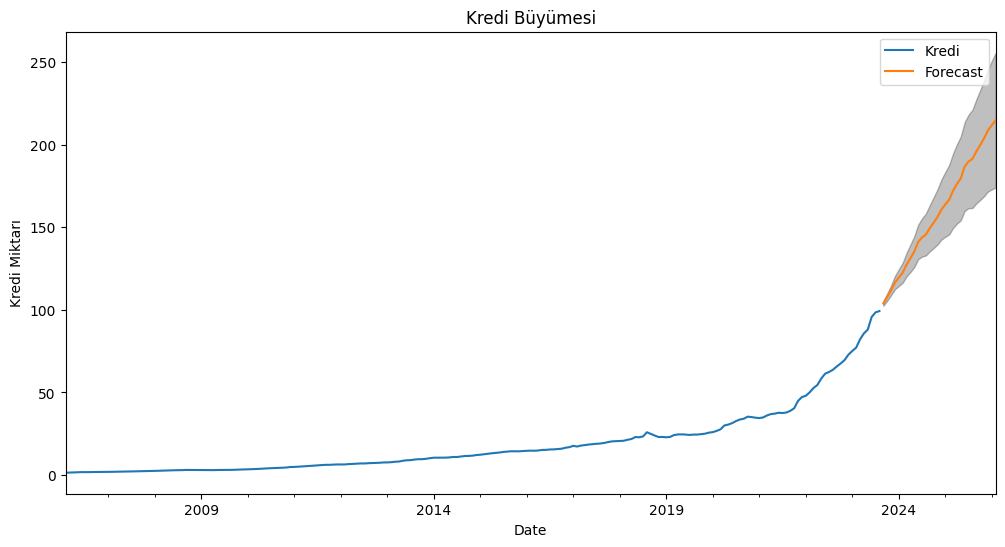

In [60]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Kredi Miktarı')
plt.title("Kredi Büyümesi")

plt.legend()

plt.show()

In [110]:
import random
pred_ci['Mean'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
kreditahmin=pred_ci["Mean"]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi Tahmin"]
kreditahmin




,Kredi Tahmin
2023-09-01,103.838529
2023-10-01,107.678894
2023-11-01,111.776263
2023-12-01,116.430791
2024-01-01,119.475756
2024-02-01,122.428741
2024-03-01,127.333921
2024-04-01,131.167127
2024-05-01,135.231214
2024-06-01,141.074359


In [111]:
z=float(input('Kredi Hacmi Aylık En Fazla % Kaç Artacağını Girin: '))
def krediassumption(z):

   drop_percentage = random.uniform(1.005, 1+(z/100))
   drop_percentage1=random.uniform(0.005, 0.01)
   kreditahmin["Kredi Tahmin Assumption 2"]=kreditahmin["Kredi Tahmin"]
   for i in range(0, len(kreditahmin)-1):
   
      kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
   return kreditahmin
krediassumption(z)
   

C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1162163530.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1162163530.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\1162163530.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,Kredi Tahmin,Kredi Tahmin Assumption 2
2023-09-01,103.838529,103.838529
2023-10-01,107.678894,104.830598
2023-11-01,111.776263,105.832145
2023-12-01,116.430791,106.843260
2024-01-01,119.475756,107.864036
2024-02-01,122.428741,108.894564
2024-03-01,127.333921,109.934938
2024-04-01,131.167127,110.985251
2024-05-01,135.231214,112.045599
2024-06-01,141.074359,113.116078


In [81]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(pfaiz.astype(float),
                                order=(3,1,0),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [82]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [83]:
pred_ci['Predicted'] = (pred_ci["lower Politika Faizi"] + pred_ci["upper Politika Faizi"])/2
pred_ci['Observed'] = pfaiz["Politika Faizi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Politika Faizi,upper Politika Faizi,Predicted,Observed,"Diff, %%"
2022-11-01,7.892768,11.964494,9.928631,9.27,7.104973
2022-12-01,5.931003,10.002729,7.966866,9.04,-11.870947
2023-01-01,6.814163,10.885887,8.850025,9.00,-1.666391
2023-02-01,6.478330,10.550054,8.514192,8.76,-2.806023
2023-03-01,6.821938,10.893621,8.857780,8.56,3.478734
2023-04-01,5.820706,9.892246,7.856476,8.70,-9.695679
2023-05-01,7.202363,11.273878,9.238120,9.09,1.629485
2023-06-01,7.093739,11.165242,9.129490,12.84,-28.898051
2023-07-01,11.662080,15.733584,13.697832,17.50,-21.726675
2023-08-01,19.170107,23.241611,21.205859,25.00,-15.176564


In [84]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

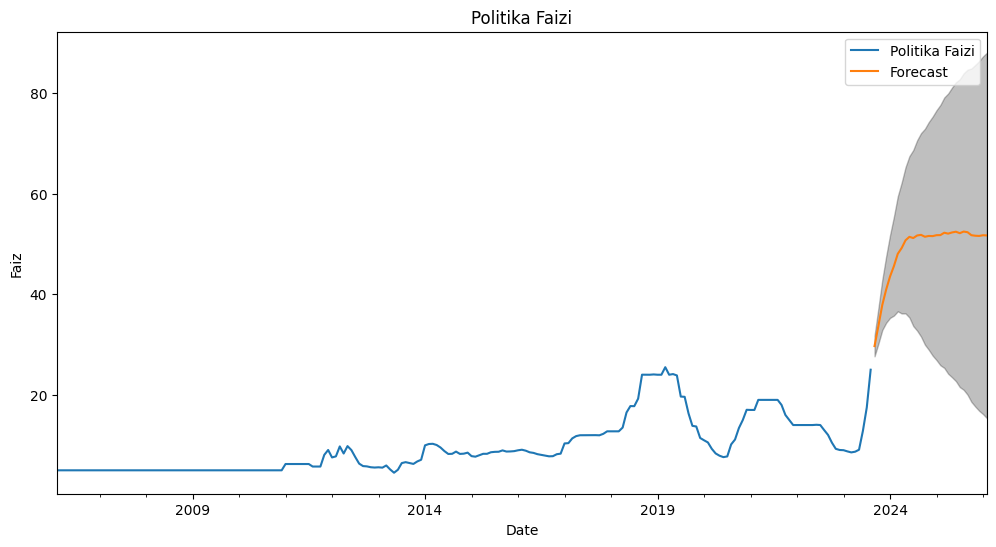

In [67]:
ax = pfaiz.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Faiz')
plt.title("Politika Faizi")

plt.legend()

plt.show()

In [85]:
pred_ci['Mean'] = (pred_ci["lower Politika Faizi"] + pred_ci["upper Politika Faizi"])/2
faiztahmin=pred_ci["Mean"]
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
faiztahmin["Politika Faizi"]=faiztahmin["Politika Faizi"].astype(int)
faiztahmin

,Politika Faizi
2023-09-01,29
2023-10-01,33
2023-11-01,37
2023-12-01,40
2024-01-01,43
2024-02-01,45
2024-03-01,48
2024-04-01,49
2024-05-01,50
2024-06-01,51


In [114]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()










res2=[]
res3=[]


for i in range(30):
    res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
    res3.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
   
    



df9=pd.DataFrame()
dates=pd.date_range('2023-09-01','2026-03-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["Inflation"]=res2
df9["Assumption 2 Inflation"]=res3
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
df9

C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\655677746.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Politika Faizi"]*faiztahmin["Politika Faizi"][i])
C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\655677746.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res3.append(results.params["const"]+results.params["Onceki USD/TL

,Inflation,Assumption 2 Inflation
2023-09-01,1635.186221,1635.186221
2023-10-01,1695.341448,1658.398010
2023-11-01,1765.641729,1687.000436
2023-12-01,1854.325971,1708.386444
2024-01-01,1913.824167,1731.846384
2024-02-01,1973.820619,1755.663996
2024-03-01,2051.755227,1779.408238
2024-04-01,2127.199157,1802.606959
2024-05-01,2212.887998,1826.007781
2024-06-01,2313.986251,1850.728606


In [115]:
dff=pd.concat([df["CPI"].head(211),df9["Inflation"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas2=pd.concat([df["CPI"].head(211),df9["Assumption 2 Inflation"]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["CPI"]
dfas2





,CPI
2006-02-01,123.840000
2006-03-01,124.180000
2006-04-01,125.840000
2006-05-01,128.200000
2006-06-01,128.630000
...,...
2025-10-01,2285.051702
2025-11-01,2315.077813
2025-12-01,2344.182576
2026-01-01,2376.496727


In [116]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas2['onceki_yil_tufe'] = dfas2['CPI'].shift(12)




# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas2['yillik_enflasyon_orani'] = ((dfas2['CPI'] / dfas2['onceki_yil_tufe']) - 1) * 100


# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas2.dropna(inplace=True)




In [117]:
dfas2=dfas2.head(228)


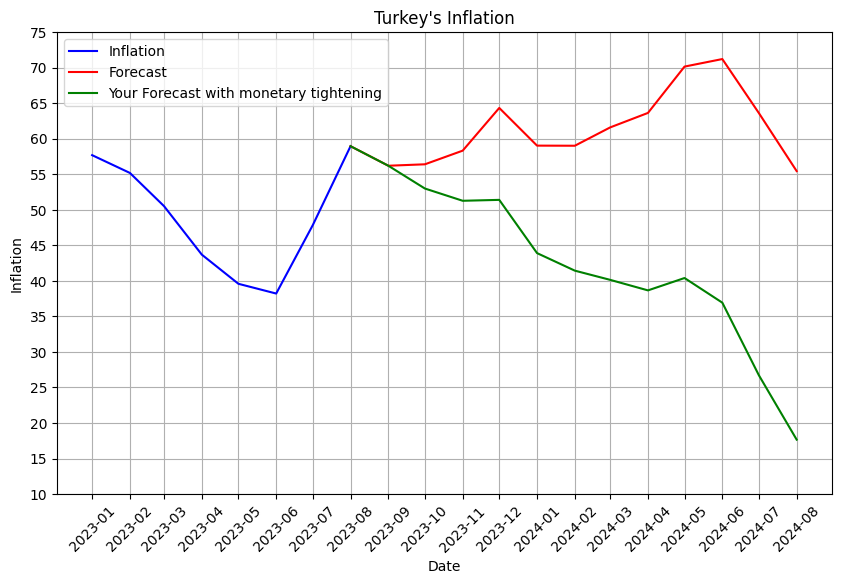

In [118]:
dates=pd.date_range('2008-02-01','2026-02-01' , freq='1M')-pd.offsets.MonthBegin(1)






# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[191:199]["yillik_enflasyon_orani"], label='Inflation', color='blue')
plt.plot(dff.iloc[198:211]["yillik_enflasyon_orani"],label='Forecast', color='red')


plt.plot(dfas2.iloc[198:211]["yillik_enflasyon_orani"],label='Your Forecast with monetary tightening', color='green')


plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dff.iloc[191:211].index, dff.iloc[191:211].index.strftime('%Y-%m'), rotation=45)
y_max = int(max(dff["yillik_enflasyon_orani"].iloc[191:211]))
y_min = 10
y_interval = 0.5
y_ticks = [y_min]
while y_ticks[-1] < y_max:
    y_ticks.append(y_ticks[-1] + 5)

# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Bora\AppData\Local\Temp\ipykernel_3800\494720330.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res6.append(results.params["const"]+results.params["Onceki USD/TL"]*df6["Onceki USD/TL"][i]+results.params["Para Arzi Onceki"]*dfn["Para Arzi Onceki"][i]+results.params["Kredi"]*df3["Kredi"][i]+results.params["Brent"]*df14["Brent"][i]+results.params["Politika Faizi"]*pfaiz["Politika Faizi"][i])


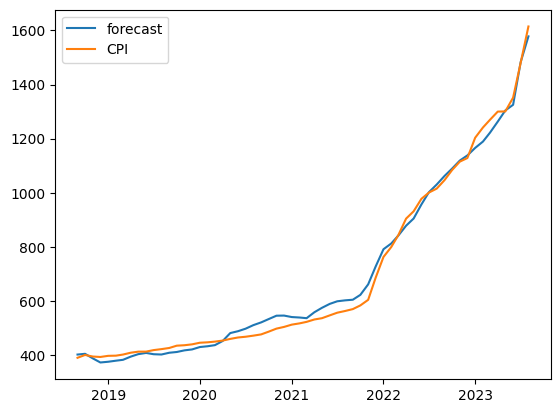

In [119]:
res6=[]
for i in range(-211,0):
    res6.append(results.params["const"]+results.params["Onceki USD/TL"]*df6["Onceki USD/TL"][i]+results.params["Para Arzi Onceki"]*dfn["Para Arzi Onceki"][i]+results.params["Kredi"]*df3["Kredi"][i]+results.params["Brent"]*df14["Brent"][i]+results.params["Politika Faizi"]*pfaiz["Politika Faizi"][i])
res6=pd.DataFrame(res6)
res6=res6.set_index(df.index)
res6.columns=["CPI"]
plt.plot(res6.tail(60),label="forecast")
plt.plot(df.tail(60),label="CPI")
plt.legend()

In [120]:
res6['onceki_yil_tufe'] = res6['CPI'].shift(12)


# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
res6['yillik_enflasyon_orani'] = ((res6['CPI'] / res6['onceki_yil_tufe']) - 1) * 100


# NaN değerleri (ilk 12 ay) veriden çıkarın
res6.dropna(inplace=True)
res6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani
2007-02-01,143.427668,136.564602,5.025509
2007-03-01,144.118655,137.637995,4.708481
2007-04-01,146.351322,140.369436,4.261530
2007-05-01,145.886922,140.887100,3.548815
2007-06-01,147.261436,143.587081,2.558973
...,...,...,...
2023-04-01,1263.140570,878.587838,43.769412
2023-05-01,1304.239640,905.124033,44.095129
2023-06-01,1325.160311,957.113710,38.453801
2023-07-01,1482.401758,1002.465885,47.875532


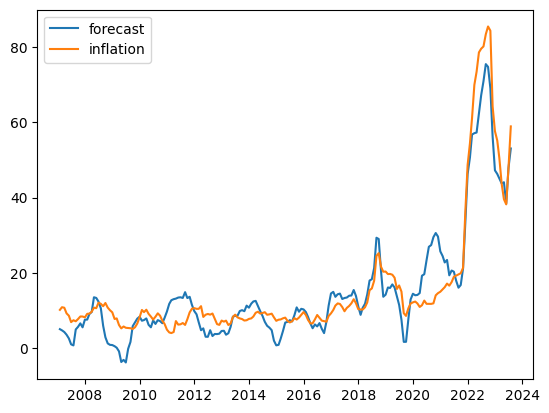

In [121]:
plt.plot(res6["yillik_enflasyon_orani"],label="forecast")
plt.plot(dff["yillik_enflasyon_orani"].head(199),label="inflation")
plt.legend()

In [122]:
dff["Onceki Ay TUFE"]=dff["CPI"].shift(1)

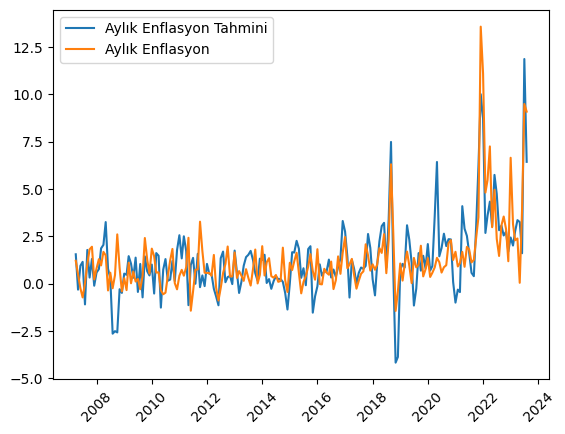

In [123]:
res6["Onceki Ay TUFE"]=res6["CPI"].shift(1)
res6["Aylık Enflasyon Tahmin"]=((res6["CPI"]/res6["Onceki Ay TUFE"]-1)*100)
res6["Gerceklesen Aylık Enflasyon"]=((dff["CPI"].head(219)/dff["Onceki Ay TUFE"].head(219)-1)*100)
plt.plot(res6["Aylık Enflasyon Tahmin"].tail(197),label="Aylık Enflasyon Tahmini")
plt.plot(res6["Gerceklesen Aylık Enflasyon"].tail(197),label="Aylık Enflasyon")
plt.xticks(rotation=45)
plt.legend()